# Model Development

This example shows how to build, train, evaluate and deploy a model running on FPGA. Only Windows is supported. We use TensorFlow and Keras to build our model. We are going to use transfer learning, with ResNet50 as a featurizer. We don't use the last layer of ResNet50 in this case and instead add and train our own classification layer.

We will use the Kaggle Cats and Dogs dataset to train the classifier. The data set can be downloaded [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765). Download the zip and extract to a directory named 'catsanddogs' under your user directory ("~/catsanddogs").

Please set up your environment as described in the [quick start](00_QuickStart.ipynb).

In [27]:
import os
import sys
import tensorflow as tf
import numpy as np
import amlrealtimeai
from amlrealtimeai import resnet50
import sys
!{sys.executable} -m pip install h5py
import h5py

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.4 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Model Construction
Load the files we are going to use for training and testing. By default this notebook uses only a very small subset of the Cats and Dogs dataset. That makes it run quickly, but doesn't create a very accurate classifier. You can improve the classifier by using more of the dataset.

We need to preprocess the input file to get it into the form expected by ResNet50. We've provided a default implementation of the preprocessing that you can use.

In [28]:
# Input images as a two-dimensional tensor containing an arbitrary number of images represented a strings
import amlrealtimeai.resnet50.utils
#datadir = os.path.expanduser("/Users/mialiu/Downloads/")
in_images = tf.placeholder(tf.string)
image_tensors = resnet50.utils.preprocess_array(in_images)
image_tensors = tf.placeholder(tf.int32,shape=(None,224, 224, 3))
#print(image_tensors.shape)
print(type(image_tensors))

<class 'tensorflow.python.framework.ops.Tensor'>


Alternatively, if you would like to customize the preprocessing, you can write your own preprocessor using TensorFlow operations.

The input to the classifier we are training is the set of features produced by ResNet50. To train the classifier we need to 
featurize the images using resnet50. We do this using a featurizer running on FPGA. You can also run the featurizer locally on CPU or GPU.

Go to our [GitHub repo](https://aka.ms/aml-real-time-ai) "docs" folder to learn how to create a Model Management Account and find the required information below.

In [29]:
subscription_id = "80defacd-509e-410c-9812-6e52ed6a0016"
resource_group = "CMS_FPGA_Resources"
model_management_account = "CMS_FPGA_1"

from amlrealtimeai.resnet50.model import RemoteQuantizedResNet50
model_path = os.path.expanduser('~/models')
featurizer = RemoteQuantizedResNet50(subscription_id, resource_group, model_management_account, model_path)
print(featurizer.version)

1.1.6-rc


Calling import_graph_def on the featurizer will create a service that runs the featurizer on FPGA.

In [30]:
featurizer.import_graph_def(include_top=False, input_tensor=image_tensors)
features = featurizer.featurizer_output

In [31]:
def preprocess_oneimage(np_array):
    image = tf.cast(np_array, dtype=tf.float32)
    output_width = 224
    output_height = 224
    resize_min = 256

    #image_grayscale = tf.image.grayscale_to_rgb(image)
    image_grayscale = image
    image_resize = tf.image.resize_images(image_grayscale, [224,224])
    #image_resize = amlrealtimeai.resnet50.utils._aspect_preserving_resize(image, resize_min)
    #image_resize = amlrealtimeai.resnet50.utils._central_crop(image, output_height, output_width)
    image_resize.set_shape([output_height, output_width, 3])
    image_resize = tf.to_float(image_resize)
    image_resize = tf.expand_dims(image_resize, 0)

    slice_red = tf.slice(image_resize, [0, 0, 0, 0], [1, 224, 224, 1])
    slice_green = tf.slice(image_resize, [0, 0, 0, 1], [1, 224, 224, 1])
    slice_blue = tf.slice(image_resize, [0, 0, 0, 2], [1, 224, 224, 1])

    #sub_red = tf.subtract(slice_red, 123.68)
    #sub_green = tf.subtract(slice_green, 116.779)
    #sub_blue = tf.subtract(slice_blue, 103.939)
    sub_red = tf.subtract(slice_red, 0)
    sub_green = tf.subtract(slice_green, 0)
    sub_blue = tf.subtract(slice_blue, 0)
    return tf.concat([sub_blue, sub_green, sub_red], 3)
def _decode(tensor):
    return tf.squeeze(preprocess_oneimage(tensor))
def preprocess_nparray(in_images):
    #tf.convert_to_tensor(in_images)
    return tf.map_fn(_decode,in_images, tf.float32)
# Load MNIST
f = h5py.File("/Users/mialiu/Downloads/jetImage_Merged.h5",'r')
a = np.array(f['jetImage']) # images
b = np.array(f["jets"])[:,-6:-1] # labels
# randomly shuffle label and images, keep the indexing
c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)]
np.random.shuffle(c)
image = c[:, :a.size//len(a)].reshape(a.shape)
onehot_labels = c[:, a.size//len(a):].reshape(b.shape)
# notebooks die if use the full dataset, needs a solution

#NUMBER_OF_DATA = image.shape[0]
NUMBER_OF_DATA = 10000
image = image[:NUMBER_OF_DATA]
onehot_labels = onehot_labels[:NUMBER_OF_DATA]
#normalize image to 0-255 per image.
image_sum = 1/np.sum(np.sum(image,axis=1),axis=-1)
given_axis = 0
# Create an array which would be used to reshape 1D array, b to have 
# singleton dimensions except for the given axis where we would put -1 
# signifying to use the entire length of elements along that axis  
dim_array = np.ones((1,image.ndim),int).ravel()
dim_array[given_axis] = -1
# Reshape b with dim_array and perform elementwise multiplication with 
# broadcasting along the singleton dimensions for the final output
image_sum_reshaped = image_sum.reshape(dim_array)
image = image*image_sum_reshaped*255

# make it rgb by duplicating 3 channels.
images = np.stack([image, image, image],axis=-1)
images_tf = tf.convert_to_tensor(images)
images_preprocessed = preprocess_nparray(images_tf)

with tf.Session() as sess:
     images_array = images_preprocessed.eval(session=sess)
f.close()


## Pre-compute features
Load the data set and compute the features. These can be precomputed because they don't change during training.

In [32]:
from tqdm import tqdm

def chunks(l, n):
    """Yield successive n-sized chunks from a file."""
    for i in range(0, l.shape[0], n):
        yield l[i:i + n]

def read_files(files):
    contents = []
    for path in files:
        with open(path, 'rb') as f:
            contents.append(f.read())
    return contents
        
feature_list = []

with tf.Session() as sess:
    for chunk in tqdm(chunks(images_array,100)):
        result= sess.run([features],feed_dict={image_tensors:chunk}) # 
        feature_list.extend(result[0])
feature_results = np.array(feature_list)
print(feature_results.shape)

0it [00:00, ?it/s]

Retrying <_Rendezvous of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "OS Error"
	debug_error_string = "{"created":"@1538750838.301193000","description":"Error received from peer","file":"src/core/lib/surface/call.cc","file_line":1099,"grpc_message":"OS Error","grpc_status":14}"
>


96it [24:26, 15.28s/it]

Retrying <_Rendezvous of RPC that terminated with:
	status = StatusCode.DEADLINE_EXCEEDED
	details = "Deadline Exceeded"
	debug_error_string = "{"created":"@1538752314.969489000","description":"Error received from peer","file":"src/core/lib/surface/call.cc","file_line":1099,"grpc_message":"Deadline Exceeded","grpc_status":4}"
>


100it [26:37, 15.97s/it]


(10000, 1, 1, 2048)


Remove remote service

In [7]:
featurizer.cleanup_remote_service()

Deleting service efad797ecce04bdaa6b4508e9ac10554
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Deleted service efad797ecce04bdaa6b4508e9ac10554
Deleting model 28058550e1bb4a0094a450602cf9d042
Deleted model 28058550e1bb4a0094a450602cf9d042


## Add and Train the classifier
We use Keras to define and train a simple classifier.

In [33]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras import optimizers

FC_SIZE = 1024
NUM_CLASSES = 5

model = Sequential()
model.add(Dropout(0.2, input_shape=(1, 1, 2048,)))
model.add(Dense(FC_SIZE, activation='relu', input_dim=(1, 1, 2048,)))
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='sigmoid', input_dim=FC_SIZE))

model.compile(optimizer=optimizers.SGD(lr=1e-4,momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])


Prepare the train and test data.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_results, onehot_labels, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7500, 1, 1, 2048) (2500, 1, 1, 2048) (7500, 5) (2500, 5)


Train the classifier.

In [35]:
model.fit(X_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
7500/7500 [==============================] - 16s 2ms/step - loss: 0.4878 - acc: 0.7967
Epoch 2/50
7500/7500 [==============================] - 13s 2ms/step - loss: 0.4553 - acc: 0.8059
Epoch 3/50
7500/7500 [==============================] - 12s 2ms/step - loss: 0.4413 - acc: 0.8135
Epoch 4/50
7500/7500 [==============================] - 13s 2ms/step - loss: 0.4330 - acc: 0.8167
Epoch 5/50
7500/7500 [==============================] - 13s 2ms/step - loss: 0.4275 - acc: 0.8190
Epoch 6/50
7500/7500 [==============================] - 12s 2ms/step - loss: 0.4218 - acc: 0.8204
Epoch 7/50
7500/7500 [==============================] - 13s 2ms/step - loss: 0.4205 - acc: 0.8207
Epoch 8/50
7500/7500 [==============================] - 12s 2ms/step - loss: 0.4160 - acc: 0.8212
Epoch 9/50
7500/7500 [==============================] - 13s 2ms/step - loss: 0.4143 - acc: 0.8222
Epoch 10/50
7500/7500 [==============================] - 13s 2ms/step - loss: 0.4126 - acc: 0.8228
Epoch 11/50
7500/75

## Test the Classifier
Let's test the classifier and see how well it does. Since we only trained on a few images, we are not expecting to win a Kaggle competition, but it will likely get most of the images correct. 

In [36]:
from numpy import argmax

y_probs = model.predict(X_test)
print(y_probs)
print(y_test)
y_prob_max = np.argmax(y_probs, 1)
y_test_max = np.argmax(y_test, 1)
print(y_prob_max)
print(y_test_max)

[[0.01658157 0.03125555 0.5458601  0.61220026 0.1181857 ]
 [0.15883648 0.06959239 0.6290691  0.44223565 0.02114807]
 [0.08048899 0.06576791 0.31376943 0.34394994 0.21043907]
 ...
 [0.23785222 0.04303741 0.04290786 0.08142955 0.70126987]
 [0.27943274 0.619417   0.12453642 0.1036687  0.014342  ]
 [0.2787286  0.15243939 0.3760189  0.2984146  0.06231593]]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[3 2 3 ... 4 1 2]
[3 3 0 ... 0 1 0]


Accuracy 0.5264
Precision [0.51923077 0.54605263 0.38896366 0.51630435 0.71017274]
Recall [0.28008299 0.65873016 0.60714286 0.36121673 0.72265625]
F1 [0.3638814  0.5971223  0.47415915 0.42505593 0.71636012]
Confusion Matrix [[135, 147, 108, 18, 74], [57, 332, 67, 16, 32], [27, 59, 289, 92, 9], [26, 61, 213, 190, 36], [15, 9, 66, 52, 370]]


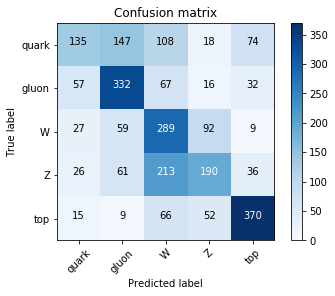

In [37]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import itertools
import matplotlib
from matplotlib import pyplot as plt

# compute a bunch of classification metrics 
def classification_metrics(y_true, y_pred, y_prob):
    cm_dict = {}
    cm_dict['Accuracy'] = accuracy_score(y_true, y_pred)
    cm_dict['Precision'] =  precision_score(y_true, y_pred, average=None)
    cm_dict['Recall'] =  recall_score(y_true, y_pred, average=None)
    cm_dict['F1'] =  f1_score(y_true, y_pred, average=None) 
    #cm_dict['AUC'] = roc_auc_score(y_true, y_prob[:,0])
    cm_dict['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()
    return cm_dict

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    New BSD License - see appendix
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0: cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cm_dict = classification_metrics(y_test_max, y_prob_max, y_probs)
for m in cm_dict:
    print(m, cm_dict[m])
cm = np.asarray(cm_dict['Confusion Matrix'])
plot_confusion_matrix(cm, ['quark','gluon','W','Z','top'], normalize=False)

## Service Definition
Like in the QuickStart notebook our service definition pipeline consists of three stages. Here we use the Keras classifier as the final stage.

In [30]:
from amlrealtimeai.pipeline import ServiceDefinition, TensorflowStage, BrainWaveStage, KerasStage

service_def = ServiceDefinition()
service_def.pipeline.append(TensorflowStage(tf.Session(), in_images, image_tensors))
service_def.pipeline.append(BrainWaveStage(featurizer))
service_def.pipeline.append(KerasStage(model))

service_def_path = os.path.join(datadir, 'save', 'service_def')
service_def.save(service_def_path)
print(service_def_path)

INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 4 variables.
Converted 4 variables to const ops.
/Users/mialiu/Downloads/kagglecatsanddogs_3367a/save/service_def


## Deploy

In [31]:
from amlrealtimeai import DeploymentClient

model_name = "catsanddogs-model"
service_name = "modelbuild-service"

deployment_client = DeploymentClient(subscription_id, resource_group, model_management_account)

The first time the code below runs it will create a new service running your model. If you want to change the model you can make changes above in this notebook and save a new service definition. Then this code will update the running service in place to run the new model.

In [32]:
service = deployment_client.get_service_by_name(service_name)
model_id = deployment_client.register_model(model_name, service_def_path)

Registering model catsanddogs-model
Successfully registered model catsanddogs-model


In [33]:
if(service is None):
    service = deployment_client.create_service(service_name, model_id)    
else:
    service = deployment_client.update_service(service.id, model_id)

Creating service modelbuild-service
. . . . . . . . . 
Successfully created service modelbuild-service


The service is now running in Azure and ready to serve requests. We can check the address and port.

In [34]:
print(service.ipAddress + ':' + str(service.port))

40.121.62.234:80


## Client
There is a simple test client at amlrealtimeai.PredictionClient which can be used for testing. We'll use this client to score an image with our new service.

In [35]:
from amlrealtimeai import PredictionClient
client = PredictionClient(service.ipAddress, service.port)

You can adapt the client [code](../../pythonlib/amlrealtimeai/client.py) to meet your needs. There is also an example C# [client](../../sample-clients/csharp).

The service provides an API that is compatible with TensorFlow Serving. There are instructions to download a sample client [here](https://www.tensorflow.org/serving/setup).

## Request
Let's see how our service does on a few images. It may get a few wrong.

In [36]:
# Specify an image to classify
print('CATS')
for image_file in cat_files[:8]:
    results = client.score_image(image_file)
    result = 'CORRECT ' if results[0] > results[1] else 'WRONG '
    print(result + str(results))
print('DOGS')
for image_file in dog_files[:8]:
    results = client.score_image(image_file)
    result = 'CORRECT ' if results[1] > results[0] else 'WRONG '
    print(result + str(results))

CATS
CORRECT [0.4911853 0.4856984]
CORRECT [0.62519485 0.3544419 ]
CORRECT [0.5897753  0.14872892]
CORRECT [0.5802131  0.35239896]
CORRECT [0.66824925 0.15894377]
CORRECT [0.76457125 0.13966438]
CORRECT [0.8094868 0.3515233]
CORRECT [0.72812706 0.20976284]
DOGS
CORRECT [0.39778802 0.49379167]
CORRECT [0.48429555 0.6952659 ]
CORRECT [0.25493044 0.8189195 ]
CORRECT [0.31072652 0.62333775]
CORRECT [0.2599125 0.6224645]
CORRECT [0.32086092 0.6722173 ]
CORRECT [0.12503223 0.763471  ]
CORRECT [0.40614098 0.40969202]


## Cleanup
Run the cell below to delete your service.

In [37]:
services = deployment_client.list_services()

for service in filter(lambda x: x.name == service_name, services):
    print(service.id)
    deployment_client.delete_service(service.id)
    
models = deployment_client.list_models()

for model in filter(lambda x: x.name == model_name, models):
    print(model.id)
    deployment_client.delete_model(model.id)

4c909171960244e4830b9bce837ba9c3
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
eff4736bda5b4daa907bd025f13c3b53
a9e748ce56184c53a41ee42382432ed0


## Appendix

License for plot_confusion_matrix:

New BSD License

Copyright (c) 2007–2018 The scikit-learn developers.
All rights reserved.


Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

  a. Redistributions of source code must retain the above copyright notice,
     this list of conditions and the following disclaimer.
  b. Redistributions in binary form must reproduce the above copyright
     notice, this list of conditions and the following disclaimer in the
     documentation and/or other materials provided with the distribution.
  c. Neither the name of the Scikit-learn Developers  nor the names of
     its contributors may be used to endorse or promote products
     derived from this software without specific prior written
     permission. 


THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
ARE DISCLAIMED. IN NO EVENT SHALL THE REGENTS OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT
LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY
OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH
DAMAGE.
